Importing Libraries

In [34]:
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [35]:
# hyperparameter setting
image_size = 224
batch_size = 32
epochs = 20

In [36]:
# input files
base_dir="C:\Datasets\Brain_Tumour"

glioma_tumor = glob.glob(base_dir + '/**/glioma_tumor/*')
meningioma_tumor = glob.glob(base_dir + '/**/meningioma_tumor/*')
pituitary_tumor = glob.glob(base_dir + '/**/pituitary_tumor/*')
normal = glob.glob(base_dir + '/**/no_tumor/*')

print("glioma_tumor : {}".format(len(glioma_tumor)))
print("meningioma_tumor : {}".format(len(meningioma_tumor)))
print("pituitary_tumor : {}".format(len(pituitary_tumor)))
print("normal : {}".format(len(normal)))

glioma_tumor : 926
meningioma_tumor : 937
pituitary_tumor : 901
normal : 500


In [37]:
# add labels
def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

glioma_tumor = add_labels(glioma_tumor, 'glioma')
meningioma_tumor = add_labels(meningioma_tumor, 'meningioma')
pituitary_tumor = add_labels(pituitary_tumor, 'pituitary')
normal = add_labels(normal, 'normal')

print(glioma_tumor[0])
print(meningioma_tumor[0])
print(pituitary_tumor[0])
print(normal[0])

('C:\\Datasets\\Brain_Tumour\\Testing\\glioma_tumor\\image(1).jpg', 'glioma')
('C:\\Datasets\\Brain_Tumour\\Testing\\meningioma_tumor\\image(1).jpg', 'meningioma')
('C:\\Datasets\\Brain_Tumour\\Testing\\pituitary_tumor\\image(1).jpg', 'pituitary')
('C:\\Datasets\\Brain_Tumour\\Testing\\no_tumor\\image(1).jpg', 'normal')


In [38]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

glioma_data = split_data(glioma_tumor)
meningioma_data = split_data(meningioma_tumor)
pituitary_data = split_data(pituitary_tumor)
normal_data = split_data(normal)

In [39]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

collect(glioma_data)
collect(meningioma_data)
collect(pituitary_data)
collect(normal_data)
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

2355 418 491


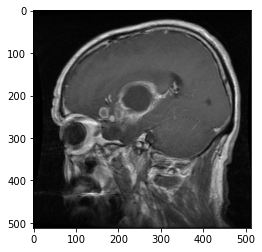

In [40]:
plt.figure()
image = cv2.imread(train_df['image'][0])
plt.imshow(image)

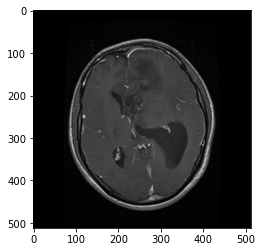

In [41]:
plt.figure()
image = cv2.imread(train_df['image'][30])
plt.imshow(image)

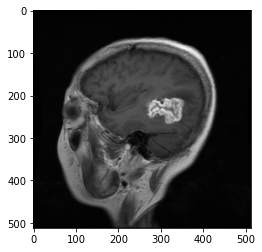

In [45]:
plt.figure()
image = cv2.imread(train_df['image'][5])
plt.imshow(image)

In [17]:
# data augmentation (train)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range = 0.1,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True)

train_set = train_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='image',
                                          y_col='label',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          shuffle=True,
                                          class_mode='categorical',
                                          color_mode='grayscale')

# rescaling (validation)
val_rescaled = ImageDataGenerator(rescale = 1./255)

val_set = val_rescaled.flow_from_dataframe(dataframe=val_df,
                                           x_col='image',
                                           y_col='label',
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical',
                                           color_mode='grayscale')


Found 2355 validated image filenames belonging to 4 classes.
Found 418 validated image filenames belonging to 4 classes.


In [18]:
# rescaling (test)
test_rescaled = ImageDataGenerator(rescale = 1./255)

test_set = test_rescaled.flow_from_dataframe(dataframe=test_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

Found 491 validated image filenames belonging to 4 classes.


In [19]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', 
           activation ='relu', input_shape = (image_size, image_size, 1)),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
     Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])


In [25]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)      

In [21]:
history = model.fit_generator(train_set,
                              steps_per_epoch=len(train_set),
                              epochs=epochs,
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              callbacks=[es]) 

Epoch 1/20
74/74 [==============================] - 164s 2s/step - loss: 1.3236 - accuracy: 0.3881 - val_loss: 1.1542 - val_accuracy: 0.5550
Epoch 2/20
74/74 [==============================] - 155s 2s/step - loss: 1.0873 - accuracy: 0.5304 - val_loss: 0.9182 - val_accuracy: 0.5813
Epoch 3/20
74/74 [==============================] - 153s 2s/step - loss: 0.9353 - accuracy: 0.5970 - val_loss: 0.7338 - val_accuracy: 0.6962
Epoch 4/20
74/74 [==============================] - 153s 2s/step - loss: 0.8200 - accuracy: 0.6552 - val_loss: 0.7055 - val_accuracy: 0.7225
Epoch 5/20
74/74 [==============================] - 156s 2s/step - loss: 0.7852 - accuracy: 0.6650 - val_loss: 0.6663 - val_accuracy: 0.7440
Epoch 6/20
74/74 [==============================] - 147s 2s/step - loss: 0.7287 - accuracy: 0.6892 - val_loss: 0.5929 - val_accuracy: 0.7392
Epoch 7/20
74/74 [==============================] - 146s 2s/step - loss: 0.6876 - accuracy: 0.7138 - val_loss: 0.5928 - val_accuracy: 0.7416
Epoch 8/20
74

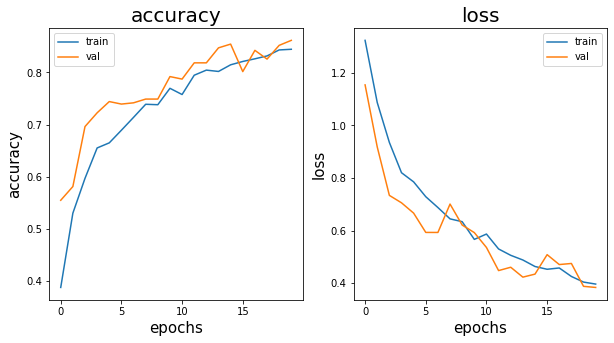

In [22]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f5dc9ab5e0>)

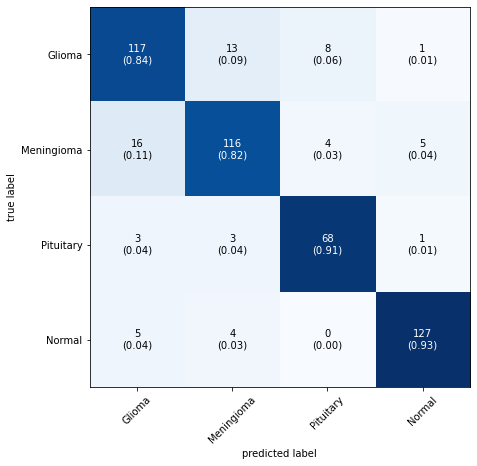

In [32]:
# test the model


#predictions = model.predict(test_set)



predictions=model.predict(test_set) 
predictions=np.argmax(predictions,axis=1)

cm = confusion_matrix(test_set.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(8,7),
                      class_names = ['Glioma','Meningioma','Pituitary', 'Normal'],
                      show_normed=True)

In [33]:
test_accuracy = (cm[0, 0] + cm[1, 1] + cm[2,2] + cm[3,3]) / len(test_set)
print("Test Accuracy: {}%".format(round(test_accuracy * 100, 3)))

Test Accuracy: 87.169%
